In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2599681102840946405, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9234857329
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1843301890956356103
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [4]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, partial, rand, space_eval
from sklearn.metrics import log_loss
import sys
import time
import math
import os
import pandas as pd
from keras.callbacks import EarlyStopping
import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize
from keras.utils.np_utils import to_categorical
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
# import keras.callbacks as kcall
from keras.optimizers import Adam, RMSprop,SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.regularizers import l2, l1

from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score

import matplotlib.pyplot as plt
from keras.layers import Input, concatenate
from keras import optimizers, metrics, models
from keras.layers import Input, Flatten, Dense

%matplotlib inline

In [5]:
import keras
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
# print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.10.0


In [6]:
# print(os.listdir(""))

In [7]:
batch_size = 512
img_height, img_width = 128, 128
input_shape = (img_height, img_width, 3)
epochs = 1000

In [8]:
train_dir = 'data/train/'
test_dir = 'data/test'

In [9]:
def preprocess_input(x):
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by imagenet mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [10]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    preprocessing_function = preprocess_input,
    validation_split= 0.2,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 319152 images belonging to 6 classes.
Found 79784 images belonging to 6 classes.
Found 13578 images belonging to 6 classes.


In [11]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 319152
nb_validation_samples: 79784
nb_test_samples: 13578

predict_size_train: 624
predict_size_validation: 156
predict_size_test: 27

 num_classes: 6


In [12]:
os.mkdir("extracted_features")
extracted_features_dir = "extracted_features/"
model_name = "InceptionV3"

In [ ]:
# vgg19_weights ="../input/full-keras-pretrained-no-top/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
# inception_weights ="../input/full-keras-pretrained-no-top//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
# vgg16_weights ="../input/full-keras-pretrained-no-top/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
# denseNet201_weights ="../input/full-keras-pretrained-no-top/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5"
# denseNet121_weights ="../input/full-keras-pretrained-no-top/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"
# resenet50_weights ="../input/full-keras-pretrained-no-top/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
# inception_resnet_v2_weights ="../input/full-keras-pretrained-no-top/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5"
# nasnet_weights ="../input/full-keras-pretrained-no-top/nasnet_large_no_top.h5"
# nasnet_mobile_weights ="../input/full-keras-pretrained-no-top/nasnet_mobile_no_top.h5"
# mobilenet_weights ="../input/full-keras-pretrained-no-top/mobilenet_1_0_224_tf_no_top.h5"
# xception_weights = "../input/full-keras-pretrained-no-top/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [13]:
# from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
# from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception, preprocess_input
from keras.applications import DenseNet201
# from keras.applications import DenseNet121
# from keras.applications import ResNet50
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications import NASNetLarge, NASNetMobile
# from keras.applications import MobileNet

In [ ]:
# input_tensor = Input(shape = input_shape)  

# base_model1=InceptionV3(input_shape= input_shape,weights=inception_weights, include_top=False, input_tensor=input_tensor)
# base_model2=Xception(input_shape= input_shape,weights=xception_weights, include_top=False, input_tensor=input_tensor)

# x1 = base_model1.output
# x1 = GlobalAveragePooling2D()(x1)

# x2 = base_model2.output
# x2 = GlobalAveragePooling2D()(x2)

# merge = concatenate([x1, x2])
# predictions = Dense(num_classes, activation='softmax')(merge)

# model = Model(inputs=input_tensor,outputs=predictions)

In [ ]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [ ]:
# c1 = model.layers[11].output 
# c1 = GlobalAveragePooling2D()(c1)       

# c2 = model.layers[21].output
# c2 = GlobalAveragePooling2D()(c2)       

# c3 = model.layers[28].output
# c3 = GlobalAveragePooling2D()(c3)       

# c4 = model.layers[51].output
# c4 = GlobalAveragePooling2D()(c4) 

# c5 = model.layers[84].output
# c5 = GlobalAveragePooling2D()(c5) 

# c6 = model.layers[103].output
# c6 = GlobalAveragePooling2D()(c6) 

# c7 = model.layers[117].output
# c7 = GlobalAveragePooling2D()(c7) 

# c8 = model.layers[129].output
# c8 = GlobalAveragePooling2D()(c8) 

# c9 = model.layers[143].output
# c9 = GlobalAveragePooling2D()(c9) 

# c10 = model.layers[162].output
# c10 = GlobalAveragePooling2D()(c10) 

# c11 = model.layers[210].output
# c11 = GlobalAveragePooling2D()(c11) 

# c12 = model.layers[258].output
# c12 = GlobalAveragePooling2D()(c12) 

# c13 = model.layers[306].output
# c13 = GlobalAveragePooling2D()(c13) 

# c14 = model.layers[356].output
# c14 = GlobalAveragePooling2D()(c14) 

# c15 = model.layers[377].output
# c15 = GlobalAveragePooling2D()(c15) 

# c16 = model.layers[415].output
# c16 = GlobalAveragePooling2D()(c16) 

# c17 = model.layers[421].output
# c17 = GlobalAveragePooling2D()(c17) 

# con = concatenate([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16])

# bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [14]:
model = InceptionV3(weights="imagenet", include_top=False, pooling = 'avg', input_tensor=Input(shape=input_shape))

In [15]:
bottleneck_final_model = model

In [16]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [17]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [18]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [19]:
# import tensorflow as tf
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

# #     config = tf.ConfigProto()
# #     config.gpu_options.allow_growth = True
# #     set_session(tf.Session(config=config))

# reset_keras_tf_session()

In [20]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [21]:
# dropout_rate = 0.5

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(2048, activation="softplus", kernel_regularizer=l2(1e-05), bias_regularizer=l2(0.0001), activity_regularizer=l1(1e-07)))
model.add(Dropout(0.25))

model.add(Dense(256, activation="softplus", kernel_regularizer=l2(1e-05), bias_regularizer=l2(0.0001), activity_regularizer=l1(1e-07)))
model.add(Dropout(0.5))
    
model.add(Dense(num_classes, activation="softmax"))

adam_opt=Adam(lr = 0.0001, beta_1=0.8, beta_2=0.99)

model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=1000,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 319152 samples, validate on 79784 samples
Epoch 1/1000
 - 10s - loss: 0.6810 - acc: 0.7825 - val_loss: 0.4930 - val_acc: 0.8464
Epoch 2/1000
 - 7s - loss: 0.4885 - acc: 0.8441 - val_loss: 0.4370 - val_acc: 0.8624
Epoch 3/1000
 - 7s - loss: 0.4392 - acc: 0.8596 - val_loss: 0.4009 - val_acc: 0.8742
Epoch 4/1000
 - 7s - loss: 0.4092 - acc: 0.8695 - val_loss: 0.3865 - val_acc: 0.8778
Epoch 5/1000
 - 7s - loss: 0.3880 - acc: 0.8757 - val_loss: 0.3695 - val_acc: 0.8827
Epoch 6/1000
 - 7s - loss: 0.3703 - acc: 0.8824 - val_loss: 0.3632 - val_acc: 0.8816
Epoch 7/1000
 - 7s - loss: 0.3560 - acc: 0.8866 - val_loss: 0.3389 - val_acc: 0.8939
Epoch 8/1000
 - 7s - loss: 0.3438 - acc: 0.8904 - val_loss: 0.3285 - val_acc: 0.8970
Epoch 9/1000
 - 7s - loss: 0.3329 - acc: 0.8949 - val_loss: 0.3191 - val_acc: 0.9006
Epoch 10/1000
 - 7s - loss: 0.3229 - acc: 0.8978 - val_loss: 0.3111 - val_acc: 0.9027
Epoch 11/1000
 - 7s - loss: 0.3143 - acc: 0.9009 - val_loss: 0.3093 - val_acc: 0.9029
Epoch 12/10

Epoch 96/1000
 - 7s - loss: 0.1430 - acc: 0.9724 - val_loss: 0.2137 - val_acc: 0.9540
Epoch 97/1000
 - 7s - loss: 0.1430 - acc: 0.9722 - val_loss: 0.2186 - val_acc: 0.9518
Epoch 98/1000
 - 7s - loss: 0.1426 - acc: 0.9726 - val_loss: 0.2175 - val_acc: 0.9530
Epoch 99/1000
 - 7s - loss: 0.1413 - acc: 0.9731 - val_loss: 0.2163 - val_acc: 0.9521
Epoch 100/1000
 - 7s - loss: 0.1405 - acc: 0.9730 - val_loss: 0.2184 - val_acc: 0.9530
Epoch 101/1000
 - 7s - loss: 0.1404 - acc: 0.9735 - val_loss: 0.2160 - val_acc: 0.9539
Epoch 102/1000
 - 7s - loss: 0.1399 - acc: 0.9737 - val_loss: 0.2189 - val_acc: 0.9536
Epoch 103/1000
 - 7s - loss: 0.1401 - acc: 0.9732 - val_loss: 0.2210 - val_acc: 0.9519
Epoch 104/1000
 - 7s - loss: 0.1401 - acc: 0.9737 - val_loss: 0.2178 - val_acc: 0.9522
Epoch 105/1000
 - 7s - loss: 0.1398 - acc: 0.9739 - val_loss: 0.2192 - val_acc: 0.9524
Epoch 106/1000
 - 7s - loss: 0.1390 - acc: 0.9742 - val_loss: 0.2157 - val_acc: 0.9541
Epoch 107/1000
 - 7s - loss: 0.1380 - acc: 0.97

Epoch 191/1000
 - 7s - loss: 0.1209 - acc: 0.9826 - val_loss: 0.2234 - val_acc: 0.9562
Epoch 192/1000
 - 7s - loss: 0.1217 - acc: 0.9824 - val_loss: 0.2206 - val_acc: 0.9571
Epoch 193/1000
 - 7s - loss: 0.1208 - acc: 0.9827 - val_loss: 0.2159 - val_acc: 0.9579
Epoch 194/1000
 - 7s - loss: 0.1206 - acc: 0.9828 - val_loss: 0.2200 - val_acc: 0.9577
Epoch 195/1000
 - 7s - loss: 0.1210 - acc: 0.9825 - val_loss: 0.2232 - val_acc: 0.9571
Epoch 196/1000
 - 7s - loss: 0.1209 - acc: 0.9827 - val_loss: 0.2204 - val_acc: 0.9583
Epoch 197/1000
 - 7s - loss: 0.1202 - acc: 0.9830 - val_loss: 0.2215 - val_acc: 0.9573
Epoch 198/1000
 - 7s - loss: 0.1206 - acc: 0.9830 - val_loss: 0.2215 - val_acc: 0.9570
Epoch 199/1000
 - 7s - loss: 0.1198 - acc: 0.9831 - val_loss: 0.2215 - val_acc: 0.9571
Epoch 200/1000
 - 7s - loss: 0.1200 - acc: 0.9829 - val_loss: 0.2232 - val_acc: 0.9558
Epoch 201/1000
 - 7s - loss: 0.1198 - acc: 0.9831 - val_loss: 0.2194 - val_acc: 0.9585
Epoch 202/1000
 - 7s - loss: 0.1200 - acc: 

 - 7s - loss: 0.1136 - acc: 0.9857 - val_loss: 0.2182 - val_acc: 0.9599
Epoch 286/1000
 - 7s - loss: 0.1148 - acc: 0.9854 - val_loss: 0.2264 - val_acc: 0.9595
Epoch 287/1000
 - 7s - loss: 0.1140 - acc: 0.9857 - val_loss: 0.2228 - val_acc: 0.9592
Epoch 288/1000
 - 7s - loss: 0.1140 - acc: 0.9855 - val_loss: 0.2133 - val_acc: 0.9589
Epoch 289/1000
 - 7s - loss: 0.1143 - acc: 0.9855 - val_loss: 0.2213 - val_acc: 0.9598
Epoch 290/1000
 - 7s - loss: 0.1136 - acc: 0.9855 - val_loss: 0.2263 - val_acc: 0.9587
Epoch 291/1000
 - 7s - loss: 0.1134 - acc: 0.9859 - val_loss: 0.2228 - val_acc: 0.9576
Epoch 292/1000
 - 7s - loss: 0.1135 - acc: 0.9855 - val_loss: 0.2203 - val_acc: 0.9591
Epoch 293/1000
 - 7s - loss: 0.1130 - acc: 0.9860 - val_loss: 0.2216 - val_acc: 0.9587
Epoch 294/1000
 - 7s - loss: 0.1135 - acc: 0.9856 - val_loss: 0.2214 - val_acc: 0.9594
Epoch 295/1000
 - 7s - loss: 0.1136 - acc: 0.9856 - val_loss: 0.2251 - val_acc: 0.9582
Epoch 296/1000
 - 7s - loss: 0.1137 - acc: 0.9855 - val_lo

Epoch 380/1000
 - 7s - loss: 0.1103 - acc: 0.9870 - val_loss: 0.2216 - val_acc: 0.9604
Epoch 381/1000
 - 7s - loss: 0.1102 - acc: 0.9869 - val_loss: 0.2279 - val_acc: 0.9573
Epoch 382/1000
 - 7s - loss: 0.1102 - acc: 0.9870 - val_loss: 0.2175 - val_acc: 0.9603
Epoch 383/1000
 - 7s - loss: 0.1103 - acc: 0.9868 - val_loss: 0.2216 - val_acc: 0.9601
Epoch 384/1000
 - 7s - loss: 0.1107 - acc: 0.9868 - val_loss: 0.2182 - val_acc: 0.9600
Epoch 385/1000
 - 7s - loss: 0.1111 - acc: 0.9866 - val_loss: 0.2164 - val_acc: 0.9604
Epoch 386/1000
 - 7s - loss: 0.1105 - acc: 0.9867 - val_loss: 0.2242 - val_acc: 0.9582
Epoch 387/1000
 - 7s - loss: 0.1108 - acc: 0.9867 - val_loss: 0.2288 - val_acc: 0.9593
Epoch 388/1000
 - 7s - loss: 0.1103 - acc: 0.9870 - val_loss: 0.2206 - val_acc: 0.9592
Epoch 389/1000
 - 7s - loss: 0.1103 - acc: 0.9867 - val_loss: 0.2281 - val_acc: 0.9593
Epoch 390/1000
 - 7s - loss: 0.1105 - acc: 0.9867 - val_loss: 0.2212 - val_acc: 0.9596
Epoch 391/1000
 - 7s - loss: 0.1104 - acc: 

 - 7s - loss: 0.1085 - acc: 0.9875 - val_loss: 0.2279 - val_acc: 0.9592
Epoch 475/1000
 - 7s - loss: 0.1089 - acc: 0.9874 - val_loss: 0.2248 - val_acc: 0.9607
Epoch 476/1000
 - 7s - loss: 0.1079 - acc: 0.9877 - val_loss: 0.2240 - val_acc: 0.9604
Epoch 477/1000
 - 7s - loss: 0.1084 - acc: 0.9874 - val_loss: 0.2276 - val_acc: 0.9596
Epoch 478/1000
 - 7s - loss: 0.1084 - acc: 0.9873 - val_loss: 0.2178 - val_acc: 0.9609
Epoch 479/1000
 - 7s - loss: 0.1086 - acc: 0.9874 - val_loss: 0.2202 - val_acc: 0.9600
Epoch 480/1000
 - 7s - loss: 0.1087 - acc: 0.9873 - val_loss: 0.2206 - val_acc: 0.9595
Epoch 481/1000
 - 7s - loss: 0.1088 - acc: 0.9874 - val_loss: 0.2191 - val_acc: 0.9607
Epoch 482/1000
 - 7s - loss: 0.1084 - acc: 0.9877 - val_loss: 0.2210 - val_acc: 0.9603
Epoch 483/1000
 - 7s - loss: 0.1080 - acc: 0.9877 - val_loss: 0.2261 - val_acc: 0.9583
Epoch 484/1000
 - 7s - loss: 0.1088 - acc: 0.9875 - val_loss: 0.2259 - val_acc: 0.9603
Epoch 485/1000
 - 7s - loss: 0.1089 - acc: 0.9872 - val_lo

Epoch 569/1000
 - 7s - loss: 0.1076 - acc: 0.9877 - val_loss: 0.2254 - val_acc: 0.9598
Epoch 570/1000
 - 7s - loss: 0.1066 - acc: 0.9881 - val_loss: 0.2233 - val_acc: 0.9592
Epoch 571/1000
 - 7s - loss: 0.1073 - acc: 0.9878 - val_loss: 0.2228 - val_acc: 0.9599
Epoch 572/1000
 - 7s - loss: 0.1069 - acc: 0.9879 - val_loss: 0.2182 - val_acc: 0.9600
Epoch 573/1000
 - 7s - loss: 0.1062 - acc: 0.9883 - val_loss: 0.2231 - val_acc: 0.9607
Epoch 574/1000
 - 7s - loss: 0.1075 - acc: 0.9877 - val_loss: 0.2137 - val_acc: 0.9609
Epoch 575/1000
 - 7s - loss: 0.1069 - acc: 0.9879 - val_loss: 0.2253 - val_acc: 0.9605
Epoch 576/1000
 - 7s - loss: 0.1068 - acc: 0.9879 - val_loss: 0.2275 - val_acc: 0.9591
Epoch 577/1000
 - 7s - loss: 0.1070 - acc: 0.9878 - val_loss: 0.2246 - val_acc: 0.9610
Epoch 578/1000
 - 7s - loss: 0.1071 - acc: 0.9880 - val_loss: 0.2218 - val_acc: 0.9610
Epoch 579/1000
 - 7s - loss: 0.1064 - acc: 0.9880 - val_loss: 0.2313 - val_acc: 0.9603
Epoch 580/1000
 - 7s - loss: 0.1065 - acc: 

 - 7s - loss: 0.1056 - acc: 0.9882 - val_loss: 0.2254 - val_acc: 0.9606
Epoch 664/1000
 - 7s - loss: 0.1061 - acc: 0.9881 - val_loss: 0.2252 - val_acc: 0.9605
Epoch 665/1000
 - 7s - loss: 0.1065 - acc: 0.9882 - val_loss: 0.2265 - val_acc: 0.9601
Epoch 666/1000
 - 7s - loss: 0.1060 - acc: 0.9882 - val_loss: 0.2327 - val_acc: 0.9594
Epoch 667/1000
 - 7s - loss: 0.1052 - acc: 0.9885 - val_loss: 0.2214 - val_acc: 0.9608
Epoch 668/1000
 - 7s - loss: 0.1060 - acc: 0.9882 - val_loss: 0.2269 - val_acc: 0.9606
Epoch 669/1000
 - 7s - loss: 0.1063 - acc: 0.9882 - val_loss: 0.2221 - val_acc: 0.9602
Epoch 670/1000
 - 7s - loss: 0.1057 - acc: 0.9885 - val_loss: 0.2184 - val_acc: 0.9611
Epoch 671/1000
 - 7s - loss: 0.1050 - acc: 0.9885 - val_loss: 0.2326 - val_acc: 0.9586
Epoch 672/1000
 - 7s - loss: 0.1056 - acc: 0.9884 - val_loss: 0.2243 - val_acc: 0.9605
Epoch 673/1000
 - 7s - loss: 0.1068 - acc: 0.9879 - val_loss: 0.2236 - val_acc: 0.9610
Epoch 674/1000
 - 7s - loss: 0.1064 - acc: 0.9881 - val_lo

Epoch 758/1000
 - 7s - loss: 0.1051 - acc: 0.9885 - val_loss: 0.2258 - val_acc: 0.9606
Epoch 759/1000
 - 7s - loss: 0.1053 - acc: 0.9882 - val_loss: 0.2159 - val_acc: 0.9607
Epoch 760/1000
 - 7s - loss: 0.1053 - acc: 0.9884 - val_loss: 0.2258 - val_acc: 0.9599
Epoch 761/1000
 - 7s - loss: 0.1053 - acc: 0.9882 - val_loss: 0.2164 - val_acc: 0.9608
Epoch 762/1000
 - 7s - loss: 0.1057 - acc: 0.9880 - val_loss: 0.2316 - val_acc: 0.9599
Epoch 763/1000
 - 7s - loss: 0.1052 - acc: 0.9886 - val_loss: 0.2188 - val_acc: 0.9602
Epoch 764/1000
 - 7s - loss: 0.1053 - acc: 0.9885 - val_loss: 0.2173 - val_acc: 0.9609
Epoch 765/1000
 - 7s - loss: 0.1047 - acc: 0.9888 - val_loss: 0.2369 - val_acc: 0.9591
Epoch 766/1000
 - 7s - loss: 0.1058 - acc: 0.9883 - val_loss: 0.2281 - val_acc: 0.9595
Epoch 767/1000
 - 7s - loss: 0.1055 - acc: 0.9882 - val_loss: 0.2163 - val_acc: 0.9607
Epoch 768/1000
 - 7s - loss: 0.1051 - acc: 0.9884 - val_loss: 0.2247 - val_acc: 0.9611
Epoch 769/1000
 - 7s - loss: 0.1045 - acc: 

 - 7s - loss: 0.1043 - acc: 0.9888 - val_loss: 0.2257 - val_acc: 0.9609
Epoch 853/1000
 - 7s - loss: 0.1048 - acc: 0.9884 - val_loss: 0.2158 - val_acc: 0.9603
Epoch 854/1000
 - 7s - loss: 0.1044 - acc: 0.9886 - val_loss: 0.2321 - val_acc: 0.9590
Epoch 855/1000
 - 7s - loss: 0.1042 - acc: 0.9886 - val_loss: 0.2239 - val_acc: 0.9611
Epoch 856/1000
 - 7s - loss: 0.1040 - acc: 0.9888 - val_loss: 0.2264 - val_acc: 0.9605
Epoch 857/1000
 - 7s - loss: 0.1041 - acc: 0.9887 - val_loss: 0.2238 - val_acc: 0.9605
Epoch 858/1000
 - 7s - loss: 0.1043 - acc: 0.9886 - val_loss: 0.2143 - val_acc: 0.9599
Epoch 859/1000
 - 7s - loss: 0.1046 - acc: 0.9884 - val_loss: 0.2137 - val_acc: 0.9603
Epoch 860/1000
 - 7s - loss: 0.1048 - acc: 0.9885 - val_loss: 0.2153 - val_acc: 0.9618
Epoch 861/1000
 - 7s - loss: 0.1044 - acc: 0.9888 - val_loss: 0.2160 - val_acc: 0.9609
Epoch 862/1000
 - 7s - loss: 0.1046 - acc: 0.9888 - val_loss: 0.2199 - val_acc: 0.9599
Epoch 863/1000
 - 7s - loss: 0.1044 - acc: 0.9888 - val_lo

Epoch 947/1000
 - 7s - loss: 0.1038 - acc: 0.9886 - val_loss: 0.2187 - val_acc: 0.9617
Epoch 948/1000
 - 7s - loss: 0.1043 - acc: 0.9887 - val_loss: 0.2275 - val_acc: 0.9611
Epoch 949/1000
 - 7s - loss: 0.1039 - acc: 0.9888 - val_loss: 0.2141 - val_acc: 0.9608
Epoch 950/1000
 - 7s - loss: 0.1030 - acc: 0.9891 - val_loss: 0.2317 - val_acc: 0.9604
Epoch 951/1000
 - 7s - loss: 0.1037 - acc: 0.9888 - val_loss: 0.2251 - val_acc: 0.9610
Epoch 952/1000
 - 7s - loss: 0.1033 - acc: 0.9889 - val_loss: 0.2219 - val_acc: 0.9610
Epoch 953/1000
 - 7s - loss: 0.1038 - acc: 0.9889 - val_loss: 0.2198 - val_acc: 0.9604
Epoch 954/1000
 - 7s - loss: 0.1042 - acc: 0.9885 - val_loss: 0.2180 - val_acc: 0.9606
Epoch 955/1000
 - 7s - loss: 0.1042 - acc: 0.9887 - val_loss: 0.2235 - val_acc: 0.9601
Epoch 956/1000
 - 7s - loss: 0.1044 - acc: 0.9885 - val_loss: 0.2205 - val_acc: 0.9605
Epoch 957/1000
 - 7s - loss: 0.1036 - acc: 0.9888 - val_loss: 0.2236 - val_acc: 0.9608
Epoch 958/1000
 - 7s - loss: 0.1034 - acc: 

In [22]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.9039622919428487


Confusion Matrix
[[2764    1   10    3   52   96]
 [   6  434   12   15   32   20]
 [   3    5 2720   40   48  263]
 [   2   18   36  991   21   29]
 [  31   18   41   27 2651   61]
 [  64    4  225   51   70 2714]]


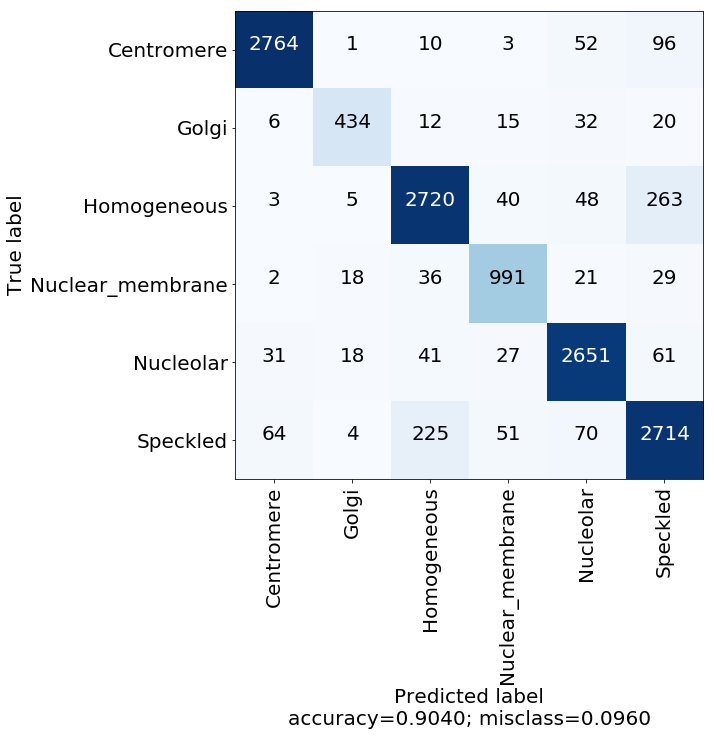

In [23]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[2764    1   10    3   52   96]
 [   6  434   12   15   32   20]
 [   3    5 2720   40   48  263]
 [   2   18   36  991   21   29]
 [  31   18   41   27 2651   61]
 [  64    4  225   51   70 2714]]
                  precision    recall  f1-score   support

      Centromere       0.96      0.94      0.95      2926
           Golgi       0.90      0.84      0.87       519
     Homogeneous       0.89      0.88      0.89      3079
Nuclear_membrane       0.88      0.90      0.89      1097
       Nucleolar       0.92      0.94      0.93      2829
        Speckled       0.85      0.87      0.86      3128

     avg / total       0.90      0.90      0.90     13578



In [25]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity )

Sensitivity :  0.9978339350180505
Specificity :  0.9977011494252873


In [26]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

13578/13578 [==============================] - 0s 30us/step
Precision =  0.9043809630186573
Recall =  0.9039622919428487
f1_score =  0.9040549487593672


In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.9395715994105869


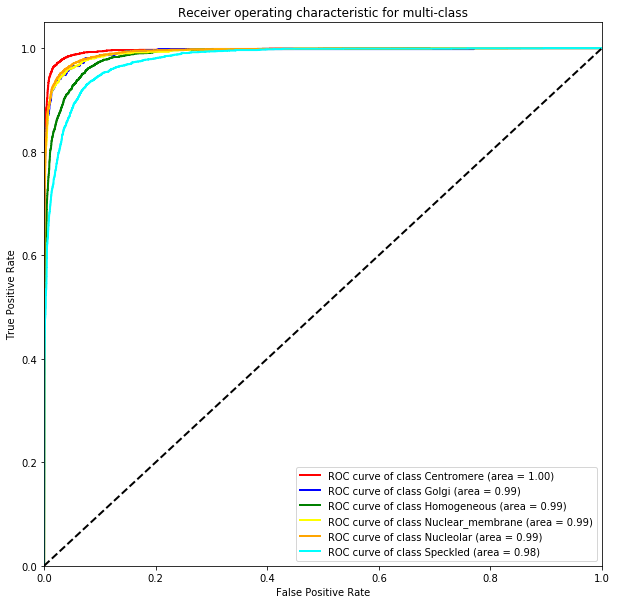

In [28]:
#ROC Curve for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy import interp
from itertools import cycle

predict_class = np.argmax(preds, axis=1)

y_pred = preds
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

y_actual_binary = label_binarize(y_actual, classes=[0, 1, 2, 3, 4, 5])
y_pred_binary = y_pred_probabilities
n_classes=6
lw=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_actual_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual_binary.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 10))


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="best")
plt.show()

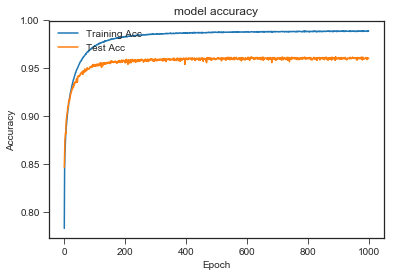

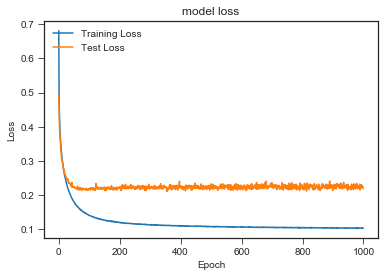

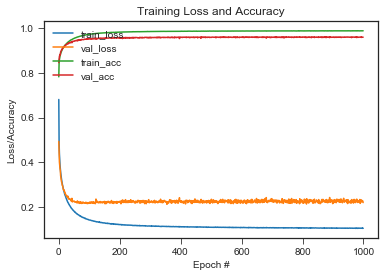

In [29]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")